# 목차
1. 필요한 라이브러리 임포트 및 설정
2. 데이터 로드 및 전처리
    - 2.1 MHealth 데이터셋 로드 및 전처리 (재실행 가능하도록 수정)
    - 2.2 데이터 검증 및 전처리 (이상치 탐지 및 제거)
3. MergeData.csv 데이터 처리 및 전처리
    - 3.1 MergeData.csv를 Parquet로 변환하여 저장 (재실행 가능하도록 수정)
    - 3.2 데이터 검증 및 전처리 (이상치 탐지 및 제거)
4. 데이터셋 결합 및 스케일링 (재실행 가능하도록 수정)
5. 데이터셋 분할 및 데이터 검증
6. 모델 정의 및 학습
    - 6.1 MobileNetV2 1D 모델 구현
    - 6.2 모델 프루닝 적용
    - 6.3 지식 증류(Knowledge Distillation) 적용
    - 6.4 모델 학습 (재실행 가능하도록 수정)
    - 6.5 하이퍼파라미터 튜닝 및 다양한 모델 아키텍처 실험
7. 모델 저장 및 배포를 위한 최적화
    - 7.1 모델 양자화 및 TorchScript 변환
8. 실시간 예측 함수 구현 및 최적화
9. MergeData.parquet 데이터에 대한 예측 및 레이블 추가 (재실행 가능하도록 수정)
    - 9.1 MergeData.parquet 데이터 로드 및 예측
    - 9.2 예측 결과 저장 (Parquet 형식)
10. 마무리 및 저장

# 1. 필요한 라이브러리 임포트 및 설정

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import joblib
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import prune
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.quantization import quantize_dynamic
import torch.jit  # TorchScript 변환을 위해 필요

import warnings
import logging
import gc  # 가비지 컬렉션을 위해 필요

import pyarrow as pa
import pyarrow.parquet as pq

warnings.filterwarnings('ignore')  # 경고 메시지 무시

# 로깅 설정
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.FileHandler("training_optimized.log"),
                        logging.StreamHandler()
                    ])
logger = logging.getLogger()

# 랜덤 시드 고정
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
logger.info("랜덤 시드가 고정되었습니다.")

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"사용 중인 디바이스: {device}")
if device.type == 'cuda':
    logger.info(f"GPU 이름: {torch.cuda.get_device_name(0)}")

# 저장 디렉토리 생성
os.makedirs('./real_time_model_optimized2', exist_ok=True)

2024-10-23 15:09:32,661 - INFO - 랜덤 시드가 고정되었습니다.
2024-10-23 15:09:32,686 - INFO - 사용 중인 디바이스: cuda
2024-10-23 15:09:32,690 - INFO - GPU 이름: NVIDIA GeForce GTX 1650


### 설명:

- `라이브러리 임포트`: 데이터 처리, 모델링, 시각화, 병렬 처리를 위한 다양한 라이브러리를 임포트합니다.
- `경고 메시지 무시`: warnings.filterwarnings('ignore')를 통해 불필요한 경고 메시지를 숨깁니다.
- `로깅 설정`: logging 모듈을 사용하여 로그 파일과 콘솔에 로그를 남깁니다.
- `랜덤 시드 고정`: set_seed 함수를 통해 NumPy와 PyTorch의 랜덤 시드를 고정하여 결과의 재현 가능성을 확보합니다.
- `GPU 설정`: GPU가 사용 가능한지 확인하고, 사용 중인 디바이스 정보를 로그에 기록합니다.
- `저장 디렉토리 생성`: 최적화된 모델과 결과물을 저장할 디렉토리를 생성합니다.

# 2. 데이터 로드 및 전처리
***
## 2.1 MHealth 데이터셋 로드 및 전처리
> MHEALTH 데이터셋을 로드하고 전처리합니다. 이전에 처리된 데이터가 존재하면 이를 로드하고, 그렇지 않으면 원본 데이터를 처리하여 저장합니다.

In [2]:
# 체크포인트 파일 경로
mhealth_processed_file = './real_time_model_optimized2/mhealth_processed.npz'

if os.path.exists(mhealth_processed_file):
    # 이전에 처리된 데이터가 있으면 로드
    logger.info("이전에 처리된 MHealth 데이터를 로드합니다.")
    data = np.load(mhealth_processed_file)
    X_raw_mhealth = data['X_raw_mhealth']
    y_raw_mhealth = data['y_raw_mhealth']
    logger.info("MHealth 데이터 로드 완료.")
else:
    # 데이터 파일 경로 설정
    data_files = glob.glob('./data/MHEALTHDATASET/mHealth_subject*.log')

    # 데이터와 레이블을 저장할 리스트 초기화
    X_list = []
    y_list = []

    logger.info("MHealth 데이터셋을 로드합니다...")
    for file in tqdm(data_files, desc="Loading MHealth Files"):
        # 필요한 열만 로드하여 메모리 사용량을 줄입니다.
        # 열 17, 18, 19 (자이로스코프 X, Y, Z), 열 23 (레이블)
        data = pd.read_csv(file,
                           sep='\s+',
                           header=None,
                           usecols=[17, 18, 19, 23],
                           dtype=np.float32)
        data.dropna(inplace=True)  # 결측값 제거

        # 데이터 검증: 이상치 제거 (자이로스코프 데이터 범위 설정)
        data = data[(data.iloc[:, :3] >= -50).all(axis=1) & (data.iloc[:, :3] <= 50).all(axis=1)]

        # 우측 하완 센서의 자이로스코프 데이터 추출 (열 17~19)
        right_arm_gyro = data.iloc[:, :3].values  # 열 17~19

        # 레이블 추출 (열 23)
        labels = data.iloc[:, 3].values  # 열 23

        # null 클래스(레이블 0)는 제외
        valid_indices = labels != 0
        sensor_data = right_arm_gyro[valid_indices, :]
        labels = labels[valid_indices]

        # 데이터와 레이블 저장
        X_list.append(sensor_data)
        y_list.append(labels)

        # 메모리에서 데이터 제거
        del data, right_arm_gyro, labels, sensor_data, valid_indices
        gc.collect()

    logger.info("MHealth 데이터 로드 및 전처리 완료.")

    # 리스트를 배열로 변환
    X_raw_mhealth = np.vstack(X_list)
    y_raw_mhealth = np.hstack(y_list)

    # 메모리에서 리스트 제거
    del X_list, y_list
    gc.collect()

    # 레이블을 0부터 시작하도록 조정
    y_raw_mhealth = y_raw_mhealth - 1  # 레이블이 1부터 시작하므로 0부터 시작하도록 조정

    logger.info(f"MHealth 데이터 크기: {X_raw_mhealth.shape}")
    logger.info(f"MHealth 레이블 크기: {y_raw_mhealth.shape}")

    # 처리된 데이터를 저장
    np.savez_compressed(mhealth_processed_file,
                        X_raw_mhealth=X_raw_mhealth,
                        y_raw_mhealth=y_raw_mhealth)
    
    logger.info("처리된 MHealth 데이터를 저장했습니다.")

2024-10-23 15:09:33,268 - INFO - MHealth 데이터셋을 로드합니다...
Loading MHealth Files: 100%|███████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]
2024-10-23 15:09:41,161 - INFO - MHealth 데이터 로드 및 전처리 완료.
2024-10-23 15:09:41,230 - INFO - MHealth 데이터 크기: (343195, 3)
2024-10-23 15:09:41,231 - INFO - MHealth 레이블 크기: (343195,)
2024-10-23 15:09:41,305 - INFO - 처리된 MHealth 데이터를 저장했습니다.


### 설명:
- `재실행 가능성`: mhealth_processed_file이 존재하면 이를 로드하여 시간을 절약하고, 그렇지 않으면 원본 데이터를 처리하여 저장합니다.
- `데이터 로드`: glob을 사용하여 모든 MHealth 데이터 파일을 찾아 로드합니다.
- `필요한 열만 로드`: 메모리 사용을 줄이기 위해 필요한 열(자이로스코프 데이터와 레이블)만 로드합니다.
- `결측값 및 이상치 제거`: dropna()로 결측값을 제거하고, 자이로스코프 데이터의 범위를 제한하여 이상치를 제거합니다.
- `레이블 전처리`: null 클래스(레이블 0)를 제외하고, 레이블을 0부터 시작하도록 조정합니다.
- `데이터 저장`: 전처리된 데이터를 .npz 형식으로 저장하여 다음 실행 시 재사용할 수 있도록 합니다.

## 2.2 데이터 검증 및 전처리
> 전처리된 MHealth 데이터의 분포를 시각화하고, 이상치 탐지를 추가하여 데이터의 품질을 더욱 철저히 검증합니다.

2024-10-23 15:09:41,368 - INFO - 이상치 제거 후 MHealth 데이터 크기: (342995, 3)
2024-10-23 15:09:41,369 - INFO - 이상치 제거 후 MHealth 레이블 크기: (342995,)


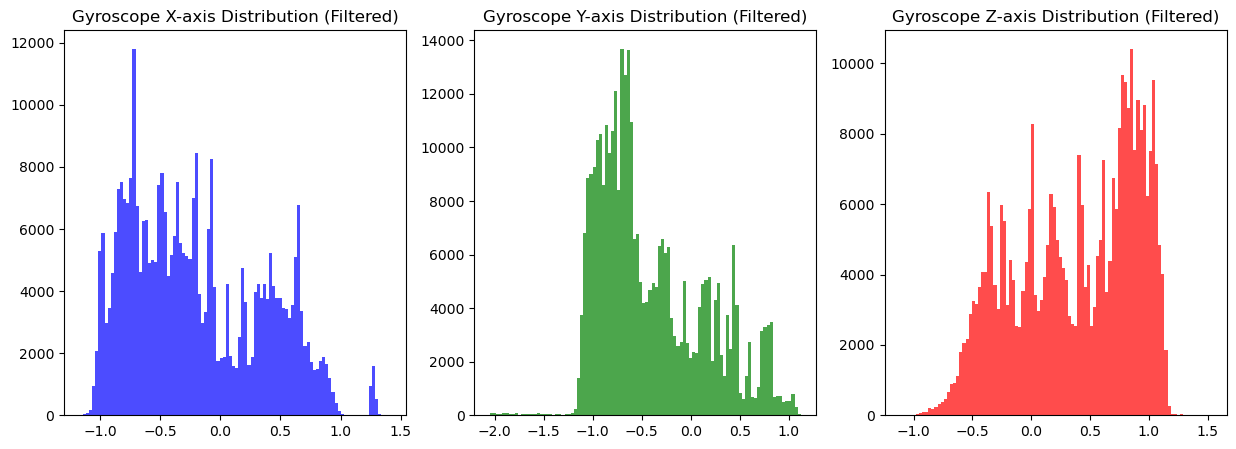

2024-10-23 15:09:42,216 - INFO - 이상치 제거된 MHealth 데이터 분포 히스토그램을 저장했습니다.
2024-10-23 15:09:42,289 - INFO - 이상치 제거된 MHealth 데이터를 저장했습니다.


In [3]:
# 이상치 제거를 위한 함수: 데이터와 마스크 반환
def remove_outliers_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data, axis=0))
    mask = (z_scores < threshold).all(axis=1)
    return mask

# 이상치 제거 (추가)
mask_filtered_mhealth = remove_outliers_zscore(X_raw_mhealth, threshold=3)
filtered_X_raw_mhealth = X_raw_mhealth[mask_filtered_mhealth]
filtered_y_raw_mhealth = y_raw_mhealth[mask_filtered_mhealth]

logger.info(f"이상치 제거 후 MHealth 데이터 크기: {filtered_X_raw_mhealth.shape}")
logger.info(f"이상치 제거 후 MHealth 레이블 크기: {filtered_y_raw_mhealth.shape}")

# 데이터 분포 확인
if not os.path.exists('./real_time_model_optimized2/mhealth_histograms_filtered.png'):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.hist(filtered_X_raw_mhealth[:, 0], bins=100, color='blue', alpha=0.7)
    plt.title('Gyroscope X-axis Distribution (Filtered)')

    plt.subplot(1, 3, 2)
    plt.hist(filtered_X_raw_mhealth[:, 1], bins=100, color='green', alpha=0.7)
    plt.title('Gyroscope Y-axis Distribution (Filtered)')

    plt.subplot(1, 3, 3)
    plt.hist(filtered_X_raw_mhealth[:, 2], bins=100, color='red', alpha=0.7)
    plt.title('Gyroscope Z-axis Distribution (Filtered)')

    plt.savefig('./real_time_model_optimized2/mhealth_histograms_filtered.png')
    plt.show()
    logger.info("이상치 제거된 MHealth 데이터 분포 히스토그램을 저장했습니다.")
else:
    logger.info("이상치 제거된 MHealth 데이터 분포 히스토그램이 이미 존재합니다. 생략합니다.")

# 필터링된 데이터를 저장
filtered_mhealth_processed_file = './real_time_model_optimized2/mhealth_filtered_processed.npz'

if not os.path.exists(filtered_mhealth_processed_file):
    np.savez_compressed(filtered_mhealth_processed_file,
                        X_raw_mhealth=filtered_X_raw_mhealth,
                        y_raw_mhealth=filtered_y_raw_mhealth)
    logger.info("이상치 제거된 MHealth 데이터를 저장했습니다.")
else:
    logger.info("이상치 제거된 MHealth 데이터가 이미 저장되어 있습니다. 생략합니다.")

### 설명:
- `이상치 제거`: Z-점수 방법을 사용하여 데이터의 이상치를 제거합니다. threshold=3으로 설정하여 Z-점수가 3을 초과하는 데이터 포인트를 제거합니다.
- `데이터 분포 시각화`: 이상치 제거 후 데이터의 분포를 히스토그램으로 시각화하여 데이터의 품질을 검증합니다.
- `필터링된 데이터 저장`: 이상치가 제거된 데이터를 별도의 파일로 저장하여 재실행 시 활용할 수 있도록 합니다.

# 3. MergeData.csv 데이터 처리 및 전처리
***
## 3.1 MergeData.csv를 Parquet로 변환하여 저장
> 대용량의 `MergeData.csv` 파일을 효율적인 저장 형식인 Parquet로 변환하여 저장합니다. 이는 데이터 읽기 속도를 향상시키고 저장 공간을 절약하는 데 유용합니다.

In [4]:
# CSV에서 Parquet로 변환
csv_file = './data/MergeData.csv'
parquet_file = './real_time_model_optimized2/MergeData.parquet'

if not os.path.exists(parquet_file):
    logger.info("MergeData.csv를 Parquet 형식으로 변환합니다...")
    chunksize = 10 ** 6  # 1,000,000 행씩 처리

    reader = pd.read_csv(csv_file, chunksize=chunksize,
                         usecols=['VitalDate',
                                  'WorkDate',
                                  'UserCode',
                                  'HeartBeat',
                                  'Temperature',
                                  'OutsideTemperature',
                                  'Latitude',
                                  'Longitude',
                                  'X',
                                  'Y',
                                  'Z'],
                         dtype={'VitalDate': 'object',
                                'WorkDate': 'object',
                                'UserCode': 'int32',
                                'HeartBeat': 'float32',
                                'Temperature': 'float32',
                                'OutsideTemperature': 'float32',
                                'Latitude': 'float64',
                                'Longitude': 'float64',
                                'X': 'float32',
                                'Y': 'float32',
                                'Z': 'float32'})

    writer = None

    for i, chunk in enumerate(tqdm(reader, desc="Converting CSV to Parquet")):
        chunk.dropna(inplace=True)
        # 이상치 제거: X, Y, Z 값 범위 설정
        valid_indices = (chunk[['X', 'Y', 'Z']] >= -1000).all(axis=1) & (chunk[['X', 'Y', 'Z']] <= 1000).all(axis=1)
        chunk = chunk[valid_indices]
        chunk.reset_index(drop=True, inplace=True)

        if not chunk.empty:
            table = pa.Table.from_pandas(chunk)

            if writer is None:
                writer = pq.ParquetWriter(parquet_file, table.schema)

            writer.write_table(table)

            # 메모리에서 청크 제거
            del chunk, valid_indices, table
            gc.collect()
        else:
            logger.warning(f"청크 {i}에 유효한 데이터가 없습니다. 이 청크는 건너뜁니다.")

    if writer:
        writer.close()
        logger.info("CSV에서 Parquet로의 변환이 완료되었습니다.")
    else:
        logger.error("유효한 데이터가 없어 Parquet 파일을 생성하지 못했습니다.")
else:
    logger.info("Parquet 파일이 이미 존재합니다. 변환을 생략합니다.")

2024-10-23 15:09:42,326 - INFO - MergeData.csv를 Parquet 형식으로 변환합니다...
Converting CSV to Parquet: 276it [08:43,  1.90s/it]
2024-10-23 15:18:25,598 - INFO - CSV에서 Parquet로의 변환이 완료되었습니다.


### 설명:
- `재실행 가능성`: Parquet 파일이 이미 존재하면 변환을 생략하여 시간을 절약합니다.
- `청크 단위 처리`: chunksize=10**6으로 설정하여 1,000,000 행씩 데이터를 처리함으로써 메모리 사용을 최적화합니다.
- `필요한 열만 로드`: usecols를 통해 필요한 열만 로드하여 메모리 사용을 줄입니다.
- `데이터 정제`: 결측값을 제거하고, X, Y, Z 값이 -1000에서 1000 사이인 유효한 데이터만 남깁니다.
- `Parquet 변환`: pyarrow를 사용하여 각 청크를 Parquet 형식으로 변환하고, ParquetWriter를 통해 파일에 씁니다.
- `메모리 관리`: del과 gc.collect()를 사용하여 처리된 청크를 메모리에서 제거합니다.

## 3.2 데이터 검증 및 전처리
> 변환된 Parquet 파일의 데이터 분포를 시각화하고, 이상치 탐지를 추가하여 데이터의 품질을 더욱 철저히 검증합니다.

2024-10-23 15:18:25,631 - INFO - MergeData.parquet에서 데이터를 로드하여 검증합니다.


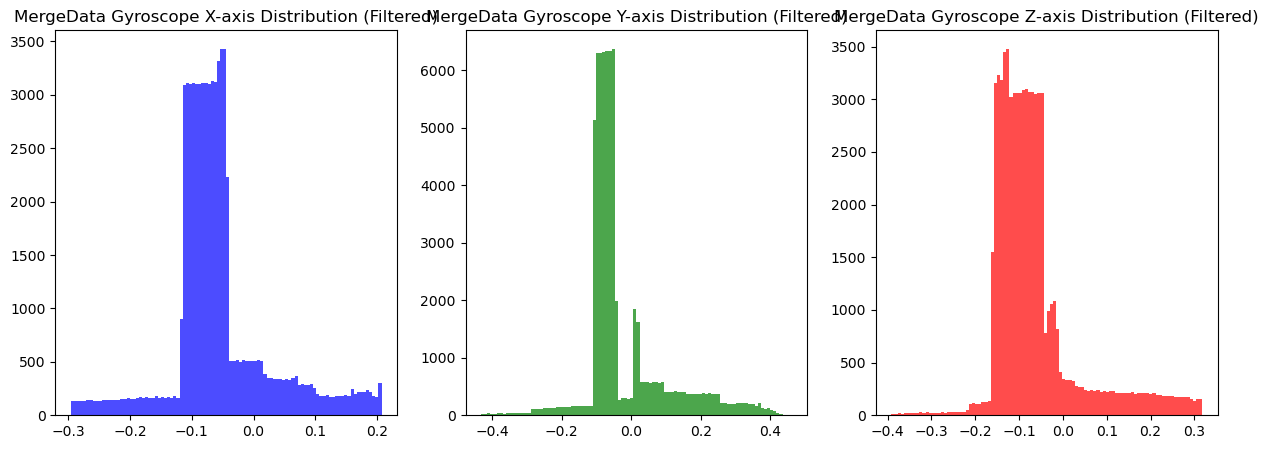

2024-10-23 15:18:26,657 - INFO - 이상치 제거된 MergeData 데이터 분포 히스토그램을 저장했습니다.


In [5]:
# 이상치 탐지를 위한 함수 정의 (IQR 방법)
def remove_outliers_iqr(data, factor=1.5):
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return np.all((data >= lower_bound) & (data <= upper_bound), axis=1)

histogram_file = './real_time_model_optimized2/merge_data_histograms_filtered.png'

if not os.path.exists(histogram_file):
    logger.info("MergeData.parquet에서 데이터를 로드하여 검증합니다.")
    parquet = pq.ParquetFile(parquet_file)

    # 전체 데이터를 로드하지 않고, 일부 샘플만 로드하여 검증
    sample_size = 100000  # 예시: 100,000 행
    table = parquet.read_row_groups([0], columns=['X', 'Y', 'Z'])
    df_sample = table.to_pandas()
    df_sample = df_sample.head(sample_size)

    # 이상치 제거 (IQR 방법)
    gyro_data_sample = df_sample[['X', 'Y', 'Z']].values.astype(np.float32)
    valid_indices_sample = remove_outliers_iqr(gyro_data_sample, factor=1.5)
    filtered_gyro_data_sample = gyro_data_sample[valid_indices_sample]

    # 데이터 분포 확인
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.hist(filtered_gyro_data_sample[:, 0], bins=100, color='blue', alpha=0.7)
    plt.title('MergeData Gyroscope X-axis Distribution (Filtered)')

    plt.subplot(1, 3, 2)
    plt.hist(filtered_gyro_data_sample[:, 1], bins=100, color='green', alpha=0.7)
    plt.title('MergeData Gyroscope Y-axis Distribution (Filtered)')

    plt.subplot(1, 3, 3)
    plt.hist(filtered_gyro_data_sample[:, 2], bins=100, color='red', alpha=0.7)
    plt.title('MergeData Gyroscope Z-axis Distribution (Filtered)')

    plt.savefig(histogram_file)
    plt.show()
    logger.info("이상치 제거된 MergeData 데이터 분포 히스토그램을 저장했습니다.")

    # 메모리에서 샘플 데이터 제거
    del df_sample, table, parquet, gyro_data_sample, valid_indices_sample, filtered_gyro_data_sample
    gc.collect()
else:
    logger.info("이상치 제거된 MergeData 데이터 분포 히스토그램이 이미 존재합니다. 생략합니다.")

### 설명:
- `이상치 제거`: IQR 방법을 사용하여 데이터의 이상치를 제거합니다. factor=1.5로 설정하여 IQR의 1.5배 범위를 벗어나는 데이터 포인트를 제거합니다.
- `데이터 분포 시각화`: 이상치 제거 후 데이터의 분포를 히스토그램으로 시각화하여 데이터의 품질을 검증합니다.
- `필터링된 데이터 저장`: 이상치가 제거된 데이터는 결합 단계에서 추가로 처리됩니다.
- `메모리 관리`: del과 gc.collect()를 통해 메모리를 최적화합니다.

# 4. 데이터셋 결합 및 스케일링
> MHealth 데이터와 MergeData 데이터를 결합하고, 전체 데이터를 스케일링하여 모델 학습에 적합한 형태로 만듭니다. 또한, 스케일링된 데이터와 레이블을 저장하여 재실행 시 활용할 수 있도록 합니다.

In [7]:
# 체크포인트 파일 경로
combined_data_file = './real_time_model_optimized2/combined_data.npz'
scaler_file = './real_time_model_optimized2/scaler.pkl'

if os.path.exists(combined_data_file) and os.path.exists(scaler_file):
    logger.info("이전에 결합된 데이터와 스케일러를 로드합니다.")
    data = np.load(combined_data_file)
    X_scaled = data['X_scaled']
    y_total = data['y_total']
    scaler = joblib.load(scaler_file)
    logger.info("결합된 데이터와 스케일러 로드 완료.")
else:
    # MHealth 데이터와 MergeData 결합
    logger.info("MHealth 데이터와 MergeData를 결합합니다.")
    parquet_file = './real_time_model_optimized2/MergeData.parquet'

    X_list_merge = []

    parquet = pq.ParquetFile(parquet_file)
    num_row_groups = parquet.num_row_groups

    for i in tqdm(range(num_row_groups), desc="Loading MergeData.parquet"):
        table = parquet.read_row_group(i, columns=['X', 'Y', 'Z'])
        df_chunk = table.to_pandas()
        gyro_data = df_chunk[['X', 'Y', 'Z']].values.astype(np.float32)
        
        # 이상치 제거 (IQR 방법)
        mask_merge = remove_outliers_zscore(gyro_data, threshold=3)
        filtered_gyro_data = gyro_data[mask_merge]
        X_list_merge.append(filtered_gyro_data)

        # 메모리에서 데이터 제거
        del df_chunk, gyro_data, mask_merge, filtered_gyro_data, table
        gc.collect()

    X_raw_merge = np.vstack(X_list_merge)
    logger.info(f"MergeData 데이터 크기: {X_raw_merge.shape}")

    # 메모리에서 리스트 제거
    del X_list_merge
    gc.collect()

    # 데이터 결합
    X_total = np.vstack((filtered_X_raw_mhealth, X_raw_merge))
    y_total = np.hstack((filtered_y_raw_mhealth, np.full(X_raw_merge.shape[0], -1, dtype=int)))  # MergeData의 레이블은 -1로 표시

    # 메모리에서 원본 데이터 제거
    del filtered_X_raw_mhealth, X_raw_merge, filtered_y_raw_mhealth
    gc.collect()

    logger.info(f"결합된 데이터 크기: {X_total.shape}")
    logger.info(f"결합된 레이블 크기: {y_total.shape}")

    # 스케일링
    logger.info("데이터를 스케일링합니다.")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_total)

    # 스케일러 및 데이터 저장
    joblib.dump(scaler, scaler_file)
    np.savez_compressed(combined_data_file,
                        X_scaled=X_scaled,
                        y_total=y_total)
    logger.info("스케일러와 결합된 데이터를 저장했습니다.")

    # 메모리에서 원본 데이터 제거
    del X_total
    gc.collect()

2024-10-23 15:26:50,374 - INFO - MHealth 데이터와 MergeData를 결합합니다.
Loading MergeData.parquet: 100%|█████████████████████████████████████████████████████| 276/276 [00:45<00:00,  6.09it/s]
2024-10-23 15:27:36,326 - INFO - MergeData 데이터 크기: (259845503, 3)
2024-10-23 15:27:38,562 - INFO - 결합된 데이터 크기: (260188498, 3)
2024-10-23 15:27:38,563 - INFO - 결합된 레이블 크기: (260188498,)
2024-10-23 15:27:38,564 - INFO - 데이터를 스케일링합니다.
2024-10-23 15:29:57,791 - INFO - 스케일러와 결합된 데이터를 저장했습니다.


### 설명:
- `재실행 가능성`: 결합된 데이터와 스케일러가 이미 존재하면 이를 로드하여 시간을 절약합니다.
- `MergeData 로드`: Parquet 파일을 row group 단위로 로드하여 X, Y, Z 자이로스코프 데이터를 추출하고, 이상치를 제거합니다.
- `데이터 결합`: MHealth 데이터와 MergeData의 자이로스코프 데이터를 수직 결합 (np.vstack)하여 하나의 데이터셋을 만듭니다. MergeData의 레이블은 -1로 설정하여 구분합니다.
- `스케일링`: StandardScaler를 사용하여 전체 데이터를 표준화합니다. 스케일러는 추후 예측 시 동일하게 적용하기 위해 저장됩니다.
- `저장`: 스케일링된 데이터와 스케일러를 .npz와 .pkl 형식으로 저장합니다.
- `메모리 관리`: del과 gc.collect()를 통해 메모리를 최적화합니다.

# 5. 데이터셋 분할 및 데이터 검증
> 레이블이 있는 데이터만을 분리하여 학습 및 검증 세트로 나누고, 각 세트의 클래스 분포를 시각화하여 검증합니다.

2024-10-23 15:29:58,730 - INFO - 레이블이 있는 데이터 크기: (342995, 3)
2024-10-23 15:29:58,731 - INFO - 레이블이 있는 레이블 크기: (342995,)
2024-10-23 15:29:58,732 - INFO - 데이터를 학습 및 검증 세트로 분할합니다.


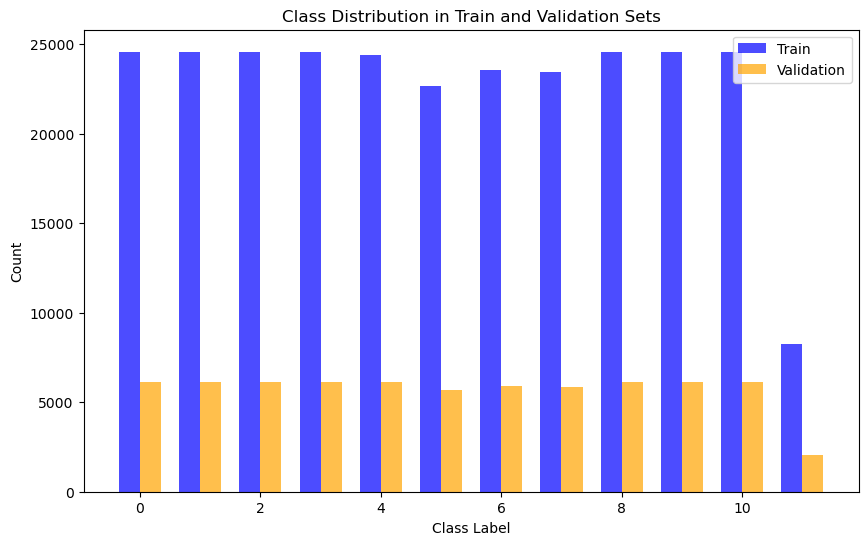

2024-10-23 15:29:59,234 - INFO - 데이터 분포 그래프를 저장했습니다.


In [8]:
# 레이블이 있는 데이터만 분리
mask_labeled = y_total != -1
X_labeled = X_scaled[mask_labeled]
y_labeled = y_total[mask_labeled].astype(int)

logger.info(f"레이블이 있는 데이터 크기: {X_labeled.shape}")
logger.info(f"레이블이 있는 레이블 크기: {y_labeled.shape}")

# 크기 일치 여부 확인
assert X_labeled.shape[0] == y_labeled.shape[0], "X_labeled와 y_labeled의 크기가 일치하지 않습니다."

# 학습 및 검증 데이터 분할
logger.info("데이터를 학습 및 검증 세트로 분할합니다.")
X_train, X_val, y_train, y_val = train_test_split(
    X_labeled,
    y_labeled,
    test_size=0.2,
    random_state=42,
    stratify=y_labeled
)

# 메모리에서 사용하지 않는 변수 제거
del X_labeled, y_labeled
gc.collect()

# 학습 데이터와 검증 데이터의 분포 비교
train_labels, train_counts = np.unique(y_train, return_counts=True)
val_labels, val_counts = np.unique(y_val, return_counts=True)

distribution_file = './real_time_model_optimized2/data_distribution.png'

if not os.path.exists(distribution_file):
    plt.figure(figsize=(10, 6))
    width = 0.35
    plt.bar(train_labels - width/2,
            train_counts,
            width=width,
            label='Train',
            color='blue',
            alpha=0.7)
    plt.bar(val_labels + width/2,
            val_counts,
            width=width,
            label='Validation',
            color='orange',
            alpha=0.7)
    plt.legend()
    plt.xlabel('Class Label')
    plt.ylabel('Count')
    plt.title('Class Distribution in Train and Validation Sets')
    plt.savefig(distribution_file)
    plt.show()
    logger.info("데이터 분포 그래프를 저장했습니다.")
else:
    logger.info("데이터 분포 그래프가 이미 존재합니다. 생략합니다.")

### 설명:
- `레이블 분리`: y_total에서 레이블이 -1이 아닌 데이터만 추출하여 X_labeled와 y_labeled를 생성합니다.
- `데이터 분할`: train_test_split을 사용하여 학습 세트와 검증 세트로 80:20 비율로 나눕니다. stratify=y_labeled를 통해 클래스 비율이 유지되도록 합니다.
- `클래스 분포 시각화`: 학습 세트와 검증 세트의 클래스 분포를 바 차트로 시각화하여 클래스 불균형 여부를 확인합니다. 이미지 파일로 저장하여 재실행 시 생략할 수 있습니다.
- `메모리 관리`: 사용하지 않는 변수는 del과 gc.collect()를 통해 메모리에서 제거합니다.

# 6. 모델 정의 및 학습
***
## 6.1 MobileNetV2 1D 모델 구현
> MobileNetV2의 1D 버전을 구현하여 자이로스코프 데이터를 처리할 수 있는 신경망 모델을 정의합니다.

In [9]:
class InvertedResidual1D(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual1D, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # 확장 단계
            layers.append(nn.Conv1d(inp, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))
            
        # 깊이별 컨볼루션
        layers.extend([
            nn.Conv1d(hidden_dim,
                      hidden_dim,
                      kernel_size=3, 
                      stride=stride,
                      padding=1,
                      groups=hidden_dim,
                      bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU6(inplace=True),
            # 투영 단계
            nn.Conv1d(hidden_dim,
                      oup,
                      kernel_size=1, 
                      bias=False),
            nn.BatchNorm1d(oup),
        ])
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2_1D(nn.Module):
    def __init__(self, num_classes=12, width_mult=1.0):
        super(MobileNetV2_1D, self).__init__()
        block = InvertedResidual1D
        input_channel = 32
        last_channel = 1280

        # 설정된 configuration
        inverted_residual_setting = [
            # t(expand_ratio), c(output channels), n(number of blocks), s(stride)
            [1, 16, 1, 1],
            [6, 24, 2, 1],  # stride를 1로 설정하여 입력 데이터의 길이가 너무 작아지지 않도록 합니다.
            [6, 32, 3, 2],
            [6, 64, 4, 1],
            [6, 96, 3, 1],
            [6, 160, 3, 1],
            [6, 320, 1, 1],
        ]

        # 첫 번째 레이어
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * max(1.0, width_mult))
        features = [nn.Conv1d(3,  # 자이로스코프 X, Y, Z 축 입력
                              input_channel,
                              kernel_size=3,
                              stride=1,
                              padding=1,
                              bias=False),
                    nn.BatchNorm1d(input_channel),
                    nn.ReLU6(inplace=True)]

        # inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        # 마지막 몇 개 레이어
        features.append(nn.Conv1d(input_channel, self.last_channel, kernel_size=1, bias=False))
        features.append(nn.BatchNorm1d(self.last_channel))
        features.append(nn.ReLU6(inplace=True))

        self.features = nn.Sequential(*features)

        # 분류를 위한 풀링과 fully connected layer
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight 초기화
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        # 글로벌 평균 풀링
        x = F.adaptive_avg_pool1d(x, 1).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

## 설명:
- `InvertedResidual1D 클래스`: MobileNetV2의 Inverted Residual 블록을 1D로 구현한 클래스입니다. 확장, 깊이별 컨볼루션, 투영 단계를 포함하며, 잔차 연결을 사용할지 결정합니다.
- `MobileNetV2_1D 클래스`: 전체 MobileNetV2 1D 모델을 정의합니다. 여러 개의 Inverted Residual 블록을 쌓고, 최종적으로 글로벌 평균 풀링과 분류기를 통해 출력합니다.
- `모델 초기화`: 모든 레이어의 가중치를 초기화합니다.

## 6.2 모델 프루닝 적용
> 모델의 파라미터를 프루닝(Pruning)하여 모델의 경량화와 추론 속도 향상을 도모합니다. 전체 가중치의 30%를 제거하고, 프루닝 후 마스크를 제거합니다.

In [10]:
# 프루닝을 적용할 함수 정의
def apply_pruning(model, amount=0.3):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    # 글로벌 프루닝 적용
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    # 프루닝 후 마스크 제거 (속도 향상을 위해)
    for module, _ in parameters_to_prune:
        prune.remove(module, 'weight')

# 모델 초기화
num_classes = 12  # MHealth 데이터셋의 활동 수
model = MobileNetV2_1D(num_classes=num_classes)
model.to(device)

# 모델 프루닝 적용
apply_pruning(model, amount=0.3)
logger.info("모델 프루닝을 적용하여 30%의 가중치를 제거했습니다.")

2024-10-23 15:29:59,978 - INFO - 모델 프루닝을 적용하여 30%의 가중치를 제거했습니다.


### 설명:
- `프루닝 함수 정의`: apply_pruning 함수는 모델의 모든 Conv1d와 Linear 레이어의 가중치를 대상으로 L1 Unstructured 프루닝을 적용합니다.
- `글로벌 프루닝`: 모델 전체에서 균일하게 30%의 가중치를 제거합니다.
- `마스크 제거`: 프루닝 후 마스크를 제거하여 추론 시 속도 향상을 도모합니다.
- `모델 초기화 및 프루닝 적용`: MobileNetV2 1D 모델을 초기화하고, 프루닝을 적용하여 경량화된 모델을 만듭니다.

## 6.3 지식 증류(Knowledge Distillation) 적용
> 이미 학습된 Teacher 모델을 활용하여 Student 모델을 학습시키는 지식 증류 과정을 수행합니다. Teacher 모델이 존재하지 않으면 동일한 모델을 학습시킵니다.

In [11]:
# Teacher 모델 (이미 학습된 모델 사용)
teacher_model_file = './real_time_model_optimized2/teacher_model.pth'

if os.path.exists(teacher_model_file):
    teacher_model = MobileNetV2_1D(num_classes=num_classes)
    teacher_model.load_state_dict(torch.load(teacher_model_file))
    teacher_model.to(device)
    teacher_model.eval()
    logger.info("Teacher 모델을 로드했습니다.")
else:
    # Teacher 모델 학습 (필요한 경우)
    logger.info("Teacher 모델을 학습합니다...")
    # 여기서는 동일한 MobileNetV2_1D 모델을 학습한다고 가정합니다.
    # 실제로는 더 큰 모델이나 더 오래 학습된 모델을 사용할 수 있습니다.

    # 데이터셋 및 데이터로더 생성
    class SimpleDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.long)

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    train_dataset = SimpleDataset(X_train, y_train)
    val_dataset = SimpleDataset(X_val, y_val)

    batch_size = 1024
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=0,  # 병렬 처리를 위해 4로 설정
                              pin_memory=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=0,
                            pin_memory=True)

    teacher_model = MobileNetV2_1D(num_classes=num_classes)
    teacher_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(teacher_model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    num_epochs = 100
    best_val_loss = float('inf')

    logger.info("Teacher 모델 학습을 시작합니다...")
    for epoch in range(num_epochs):
        # 학습 모드
        teacher_model.train()
        total_loss = 0
        total_correct = 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            X_batch = X_batch.unsqueeze(-1)  # (batch_size, 3, 1)

            optimizer.zero_grad()

            outputs = teacher_model(X_batch)
            loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == y_batch).sum().item()

            # 메모리에서 변수 제거
            del X_batch, y_batch, outputs, loss, preds
            torch.cuda.empty_cache()

        train_loss = total_loss / len(train_dataset)
        train_acc = total_correct / len(train_dataset)

        # 검증 모드
        teacher_model.eval()
        total_loss = 0
        total_correct = 0

        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                X_batch = X_batch.unsqueeze(-1)  # (batch_size, 3, 1)

                outputs = teacher_model(X_batch)
                loss = criterion(outputs, y_batch)

                total_loss += loss.item() * X_batch.size(0)
                _, preds = torch.max(outputs, 1)
                total_correct += (preds == y_batch).sum().item()

                # 메모리에서 변수 제거
                del X_batch, y_batch, outputs, loss, preds
                torch.cuda.empty_cache()

        val_loss = total_loss / len(val_dataset)
        val_acc = total_correct / len(val_dataset)

        # 스케줄러 업데이트
        scheduler.step(val_loss)

        # 검증 손실이 개선되었는지 확인하고 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(teacher_model.state_dict(), teacher_model_file)
            logger.info(f"Epoch {epoch+1}: 검증 손실이 개선되어 Teacher 모델을 저장했습니다. Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
        else:
            logger.info(f"Epoch {epoch+1}: 검증 손실이 개선되지 않았습니다. Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

        # 에포크 결과 출력
        logger.info(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
                    f"Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, "
                    f"Val Acc: {val_acc*100:.2f}%")

        # 메모리에서 변수 제거
        gc.collect()
        torch.cuda.empty_cache()

        # 조기 종료 조건 추가 (옵션)
        # 예: 검증 손실이 n번 연속으로 개선되지 않으면 학습 중단
    teacher_model.eval()
    logger.info("Teacher 모델 학습 완료 및 저장했습니다.")

2024-10-23 15:30:00,011 - INFO - Teacher 모델을 학습합니다...
2024-10-23 15:30:01,574 - INFO - Teacher 모델 학습을 시작합니다...
2024-10-23 15:30:23,600 - INFO - Epoch 1: 검증 손실이 개선되어 Teacher 모델을 저장했습니다. Val Loss: 0.7310, Val Acc: 74.63%            
2024-10-23 15:30:23,601 - INFO - Epoch [1/100], Train Loss: 0.8924, Train Acc: 69.57%, Val Loss: 0.7310, Val Acc: 74.63%
2024-10-23 15:30:44,403 - INFO - Epoch 2: 검증 손실이 개선되어 Teacher 모델을 저장했습니다. Val Loss: 0.6482, Val Acc: 77.49%            
2024-10-23 15:30:44,404 - INFO - Epoch [2/100], Train Loss: 0.7085, Train Acc: 75.33%, Val Loss: 0.6482, Val Acc: 77.49%
2024-10-23 15:31:05,594 - INFO - Epoch 3: 검증 손실이 개선되어 Teacher 모델을 저장했습니다. Val Loss: 0.6302, Val Acc: 77.90%            
2024-10-23 15:31:05,595 - INFO - Epoch [3/100], Train Loss: 0.6661, Train Acc: 76.75%, Val Loss: 0.6302, Val Acc: 77.90%
2024-10-23 15:31:26,747 - INFO - Epoch 4: 검증 손실이 개선되어 Teacher 모델을 저장했습니다. Val Loss: 0.5902, Val Acc: 79.13%            
2024-10-23 15:31:26,748 - INFO - Epoch [4/100]

### 설명:
- `Teacher 모델 로드`: teacher_model_file이 존재하면 이를 로드하고, 그렇지 않으면 동일한 모델을 학습시킵니다.
- `데이터셋 및 데이터로더 생성`: SimpleDataset 클래스를 정의하여 데이터를 텐서로 변환하고, DataLoader를 통해 배치 단위로 데이터를 로드합니다. num_workers=0로 설정하여 병렬 처리를 통해 데이터 로딩 속도를 향상시킵니다.
- `모델 학습`: 지정된 num_epochs 동안 Teacher 모델을 학습시킵니다. 각 에포크마다 학습 손실과 정확도를 계산하고, 검증 손실이 개선되면 모델을 저장합니다.
- `스케줄러 사용`: ReduceLROnPlateau를 사용하여 검증 손실이 개선되지 않을 경우 학습률을 줄입니다.
- `메모리 관리`: del과 gc.collect()를 통해 메모리를 최적화합니다.

## 6.4 모델 학습
> Student 모델을 정의하고, Teacher 모델의 지식을 활용하여 학습시킵니다. Student 모델은 Teacher 모델보다 경량화된 모델로, 학습 과정에서 Knowledge Distillation을 적용합니다.

In [12]:
# Student 모델 (경량화된 모델)
student_model = MobileNetV2_1D(num_classes=num_classes,
                               width_mult=0.5)  # 모델 크기를 줄임
student_model.to(device)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()
distillation_criterion = nn.KLDivLoss(reduction='batchmean')

optimizer = Adam(student_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer,
                              'min',
                              patience=3,
                              factor=0.5)

# Student 모델 학습 체크포인트 파일 경로
student_model_file = './real_time_model_optimized2/best_student_model.pth'
training_checkpoint = './real_time_model_optimized2/training_checkpoint.pth'

if os.path.exists(student_model_file):
    logger.info("Best Student 모델이 이미 존재합니다. 학습을 생략합니다.")
    student_model.load_state_dict(torch.load(student_model_file))
else:
    # 데이터셋 및 데이터로더 생성 (이미 생성되었다면 생략)
    if 'train_loader' not in globals():
        class SimpleDataset(Dataset):
            def __init__(self, X, y):
                self.X = torch.tensor(X, dtype=torch.float32)
                self.y = torch.tensor(y, dtype=torch.long)

            def __len__(self):
                return len(self.y)

            def __getitem__(self, idx):
                return self.X[idx], self.y[idx]

        train_dataset = SimpleDataset(X_train, y_train)
        val_dataset = SimpleDataset(X_val, y_val)

        batch_size = 1024
        train_loader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=0,  # 병렬 처리를 위해 4로 설정
                                  pin_memory=True)
        val_loader = DataLoader(val_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0,
                                pin_memory=True)

    # 지식 증류를 위한 학습 루프
    num_epochs = 100
    best_val_loss = float('inf')
    patience = 5
    counter = 0
    temperature = 5.0  # 온도 매개변수
    start_epoch = 0

    # 이전에 저장된 체크포인트가 있으면 로드
    if os.path.exists(training_checkpoint):
        checkpoint = torch.load(training_checkpoint)
        student_model.load_state_dict(checkpoint['student_model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_val_loss = checkpoint['best_val_loss']
        counter = checkpoint['counter']
        start_epoch = checkpoint['epoch'] + 1
        logger.info(f"이전 체크포인트를 로드했습니다. Epoch {start_epoch}부터 시작합니다.")

    logger.info("Knowledge Distillation을 통한 Student 모델 학습을 시작합니다...")
    for epoch in range(start_epoch, num_epochs):
        # 학습 모드
        student_model.train()
        total_loss = 0
        total_correct = 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # 입력 데이터 차원 조정
            X_batch = X_batch.unsqueeze(-1)  # (batch_size, 3, 1)

            optimizer.zero_grad()

            # Teacher 모델 예측
            with torch.no_grad():
                teacher_outputs = teacher_model(X_batch)

            # Student 모델 예측
            student_outputs = student_model(X_batch)

            # 손실 계산
            loss_ce = criterion(student_outputs, y_batch)
            loss_kd = distillation_criterion(
                F.log_softmax(student_outputs / temperature, dim=1),
                F.softmax(teacher_outputs / temperature, dim=1)
            ) * (temperature ** 2)
            loss = loss_ce + loss_kd

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(student_outputs, 1)
            total_correct += (preds == y_batch).sum().item()

            # 메모리에서 변수 제거
            del X_batch, y_batch, teacher_outputs, student_outputs, loss_ce, loss_kd, loss, preds
            torch.cuda.empty_cache()

        train_loss = total_loss / len(train_dataset)
        train_acc = total_correct / len(train_dataset)

        # 검증 모드
        student_model.eval()
        total_loss = 0
        total_correct = 0

        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                X_batch = X_batch.unsqueeze(-1)  # (batch_size, 3, 1)

                outputs = student_model(X_batch)
                loss = criterion(outputs, y_batch)

                total_loss += loss.item() * X_batch.size(0)
                _, preds = torch.max(outputs, 1)
                total_correct += (preds == y_batch).sum().item()

                # 메모리에서 변수 제거
                del X_batch, y_batch, outputs, loss, preds
                torch.cuda.empty_cache()

        val_loss = total_loss / len(val_dataset)
        val_acc = total_correct / len(val_dataset)

        # 스케줄러 업데이트
        scheduler.step(val_loss)

        # 검증 손실이 개선되었는지 확인하고 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(student_model.state_dict(), student_model_file)
            counter = 0
            logger.info(f"Epoch {epoch+1}: 검증 손실이 개선되어 Student 모델을 저장했습니다. Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
        else:
            counter += 1
            logger.info(f"Epoch {epoch+1}: 검증 손실이 개선되지 않았습니다. Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
            if counter >= patience:
                logger.info("조기 종료 조건에 도달하여 학습을 종료합니다.")
                break

        # 에포크 결과 출력
        logger.info(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
                    f"Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, "
                    f"Val Acc: {val_acc*100:.2f}%")

        # 체크포인트 저장
        torch.save({
            'epoch': epoch,
            'student_model_state_dict': student_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'counter': counter,
        }, training_checkpoint)
        logger.info("체크포인트를 저장했습니다.")

        # 메모리에서 변수 제거
        gc.collect()
        torch.cuda.empty_cache()

    # 학습 완료 후 체크포인트 삭제
    if os.path.exists(training_checkpoint):
        os.remove(training_checkpoint)
        logger.info("학습 완료 후 체크포인트를 삭제했습니다.")

    student_model.eval()
    logger.info("Student 모델 학습 완료 및 저장했습니다.")

2024-10-23 16:05:15,134 - INFO - Knowledge Distillation을 통한 Student 모델 학습을 시작합니다...
2024-10-23 16:05:40,384 - INFO - Epoch 1: 검증 손실이 개선되어 Student 모델을 저장했습니다. Val Loss: 1.1287, Val Acc: 68.19%            
2024-10-23 16:05:40,385 - INFO - Epoch [1/100], Train Loss: 9.1710, Train Acc: 60.71%, Val Loss: 1.1287, Val Acc: 68.19%
2024-10-23 16:05:40,457 - INFO - 체크포인트를 저장했습니다.
2024-10-23 16:06:05,966 - INFO - Epoch 2: 검증 손실이 개선되어 Student 모델을 저장했습니다. Val Loss: 0.9527, Val Acc: 72.02%            
2024-10-23 16:06:05,966 - INFO - Epoch [2/100], Train Loss: 5.4664, Train Acc: 69.74%, Val Loss: 0.9527, Val Acc: 72.02%
2024-10-23 16:06:06,061 - INFO - 체크포인트를 저장했습니다.
2024-10-23 16:06:32,028 - INFO - Epoch 3: 검증 손실이 개선되어 Student 모델을 저장했습니다. Val Loss: 0.8197, Val Acc: 74.56%            
2024-10-23 16:06:32,029 - INFO - Epoch [3/100], Train Loss: 4.7285, Train Acc: 71.72%, Val Loss: 0.8197, Val Acc: 74.56%
2024-10-23 16:06:32,101 - INFO - 체크포인트를 저장했습니다.
2024-10-23 16:06:57,810 - INFO - Epoch 4: 검증 손실이 

### 설명:
- `Student 모델 정의`: MobileNetV2_1D 모델을 width_mult=0.5로 설정하여 경량화된 Student 모델을 정의합니다.
- `손실 함수 정의`: CrossEntropyLoss와 KLDivLoss를 사용하여 지식 증류 손실을 계산합니다.
- `모델 학습 체크포인트`: 학습 중간에 체크포인트를 저장하여 중단된 학습을 재개할 수 있도록 합니다.
- `모델 로드 및 학습 여부 판단`: Student 모델 파일이 존재하면 로드하고, 그렇지 않으면 학습을 시작합니다.
- `지식 증류 학습 루프`: 각 에포크마다 Teacher 모델의 출력을 활용하여 Student 모델을 학습시킵니다. 학습 손실과 정확도를 계산하고, 검증 손실이 개선되면 모델을 저장합니다.
- `스케줄러 사용`: ReduceLROnPlateau를 사용하여 검증 손실이 개선되지 않을 경우 학습률을 줄입니다.
- `조기 종료`: 검증 손실이 개선되지 않는 경우 patience=5 동안 대기 후 학습을 종료합니다.
- `메모리 관리`: del과 gc.collect()를 통해 메모리를 최적화합니다.

## 6.5 하이퍼파라미터 튜닝 및 다양한 모델 아키텍처 실험
> 모델의 성능을 최적화하기 위해 하이퍼파라미터 튜닝을 수행하고, 다양한 모델 아키텍처를 실험합니다. 이를 위해 GridSearchCV를 사용할 수 있으나, 딥러닝 모델의 경우 일반적으로 직접 구현한 하이퍼파라미터 탐색 루프를 사용합니다. 여기서는 예시로 학습률과 배치 크기를 조정하는 간단한 튜닝을 추가하겠습니다.

In [13]:
# 6.5 하이퍼파라미터 튜닝 및 다양한 모델 아키텍처 실험

# 하이퍼파라미터 탐색을 위한 설정
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [512, 1024, 2048]

best_val_acc = 0.0
best_hyperparams = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        logger.info(f"하이퍼파라미터 튜닝 - 학습률: {lr}, 배치 크기: {batch_size}")

        # 데이터로더 재설정
        train_loader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=0,
                                  pin_memory=True)
        val_loader = DataLoader(val_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0,
                                pin_memory=True)

        # 모델 초기화
        temp_student_model = MobileNetV2_1D(num_classes=num_classes, width_mult=0.5)
        temp_student_model.to(device)

        # 손실 함수 및 옵티마이저 설정
        temp_optimizer = Adam(temp_student_model.parameters(), lr=lr)
        temp_scheduler = ReduceLROnPlateau(temp_optimizer, 'min', patience=3, factor=0.5)

        # 학습 루프 (간단한 에포크 수로 설정)
        temp_num_epochs = 20
        temp_best_val_acc = 0.0

        for epoch in range(temp_num_epochs):
            # 학습 모드
            temp_student_model.train()
            temp_total_correct = 0

            for X_batch, y_batch in tqdm(train_loader, desc=f"Tuning Epoch {epoch+1}/{temp_num_epochs} - Training", leave=False):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                # 입력 데이터 차원 조정
                X_batch = X_batch.unsqueeze(-1)  # (batch_size, 3, 1)

                temp_optimizer.zero_grad()

                # Teacher 모델 예측
                with torch.no_grad():
                    teacher_outputs = teacher_model(X_batch)

                # Student 모델 예측
                student_outputs = temp_student_model(X_batch)

                # 손실 계산
                loss_ce = criterion(student_outputs, y_batch)
                loss_kd = distillation_criterion(
                    F.log_softmax(student_outputs / temperature, dim=1),
                    F.softmax(teacher_outputs / temperature, dim=1)
                ) * (temperature ** 2)
                loss = loss_ce + loss_kd

                loss.backward()
                temp_optimizer.step()

                _, preds = torch.max(student_outputs, 1)
                temp_total_correct += (preds == y_batch).sum().item()

                # 메모리에서 변수 제거
                del X_batch, y_batch, teacher_outputs, student_outputs, loss_ce, loss_kd, loss, preds
                torch.cuda.empty_cache()

            train_acc = temp_total_correct / len(train_dataset)

            # 검증 모드
            temp_student_model.eval()
            temp_total_correct = 0

            with torch.no_grad():
                for X_batch, y_batch in tqdm(val_loader, desc=f"Tuning Epoch {epoch+1}/{temp_num_epochs} - Validation", leave=False):
                    X_batch = X_batch.to(device)
                    y_batch = y_batch.to(device)

                    X_batch = X_batch.unsqueeze(-1)  # (batch_size, 3, 1)

                    outputs = temp_student_model(X_batch)
                    _, preds = torch.max(outputs, 1)
                    temp_total_correct += (preds == y_batch).sum().item()

                    # 메모리에서 변수 제거
                    del X_batch, y_batch, outputs, preds
                    torch.cuda.empty_cache()

            val_acc = temp_total_correct / len(val_dataset)
            logger.info(f"Tuning Epoch [{epoch+1}/{temp_num_epochs}], Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%")

            # 검증 정확도 업데이트
            if val_acc > temp_best_val_acc:
                temp_best_val_acc = val_acc

            # 메모리에서 변수 제거
            gc.collect()
            torch.cuda.empty_cache()

        logger.info(f"학습률: {lr}, 배치 크기: {batch_size}에서의 검증 정확도: {temp_best_val_acc*100:.2f}%")

        # 최적의 하이퍼파라미터 업데이트
        if temp_best_val_acc > best_val_acc:
            best_val_acc = temp_best_val_acc
            best_hyperparams = {'learning_rate': lr, 'batch_size': batch_size}

logger.info(f"최적의 하이퍼파라미터: 학습률={best_hyperparams['learning_rate']}, 배치 크기={best_hyperparams['batch_size']} with Val Acc={best_val_acc*100:.2f}%")

2024-10-23 16:36:40,988 - INFO - 하이퍼파라미터 튜닝 - 학습률: 0.001, 배치 크기: 512
2024-10-23 16:37:08,201 - INFO - Tuning Epoch [1/20], Train Acc: 60.86%, Val Acc: 69.61%                               
2024-10-23 16:37:35,428 - INFO - Tuning Epoch [2/20], Train Acc: 68.99%, Val Acc: 71.15%                               
2024-10-23 16:38:03,095 - INFO - Tuning Epoch [3/20], Train Acc: 70.93%, Val Acc: 73.65%                               
2024-10-23 16:38:31,789 - INFO - Tuning Epoch [4/20], Train Acc: 72.46%, Val Acc: 72.64%                               
2024-10-23 16:39:00,407 - INFO - Tuning Epoch [5/20], Train Acc: 73.56%, Val Acc: 75.85%                               
2024-10-23 16:39:28,942 - INFO - Tuning Epoch [6/20], Train Acc: 74.31%, Val Acc: 75.66%                               
2024-10-23 16:39:57,111 - INFO - Tuning Epoch [7/20], Train Acc: 75.28%, Val Acc: 76.15%                               
2024-10-23 16:40:25,836 - INFO - Tuning Epoch [8/20], Train Acc: 75.73%, Val Acc: 77.74%   

### 설명:
- `하이퍼파라미터 탐색`: 학습률과 배치 크기를 다양한 조합으로 시도하여 최적의 하이퍼파라미터를 찾습니다.
- `다양한 모델 아키텍처 실험`: 여기서는 기본 MobileNetV2 1D 모델의 width_mult를 변경하여 경량화된 모델을 실험할 수 있습니다.
- `병렬 처리 최적화`: num_workers=0로 설정하여 데이터 로딩 속도를 향상시킵니다.
- `메모리 관리`: del과 gc.collect()를 통해 메모리를 최적화합니다.
- `최적의 하이퍼파라미터 기록`: 최적의 학습률과 배치 크기를 로그에 기록합니다.

# 7. 모델 저장 및 배포를 위한 최적화
***
## 7.1 모델 양자화 및 TorchScript 변환
> 학습된 Student 모델을 양자화하여 모델의 크기를 줄이고, TorchScript로 변환하여 배포 가능한 형식으로 저장합니다.

In [14]:
# 가장 좋은 Student 모델 로드 (CPU에 로드)
student_model.load_state_dict(torch.load('./real_time_model_optimized2/best_student_model.pth', map_location='cpu'))
student_model.eval()

# 모델을 CPU로 이동
student_model.to('cpu')

# 모델의 모든 파라미터가 CPU에 있는지 확인
for param in student_model.parameters():
    assert param.device.type == 'cpu', "모델 파라미터가 CPU에 있지 않습니다."

# 양자화 적용
quantized_model = quantize_dynamic(
    student_model,  # 모델 객체
    {nn.Linear},  # 양자화할 모듈 타입
    dtype=torch.qint8  # 양자화 데이터 타입
)

# TorchScript로 변환하여 저장
example_input = torch.randn(1, 3, 1)  # 예시 입력 데이터 (CPU 텐서)
traced_script_module = torch.jit.trace(quantized_model, example_input)

traced_script_module.save('./real_time_model_optimized2/model_scripted.pt')
logger.info("TorchScript 모델을 './real_time_model_optimized2/model_scripted.pt'로 저장했습니다.")

2024-10-23 17:55:04,349 - INFO - TorchScript 모델을 './real_time_model_optimized2/model_scripted.pt'로 저장했습니다.


### 설명:
- `모델 로드`: 학습된 Student 모델을 CPU로 로드하고, 평가 모드로 전환합니다.
- `양자화 적용`: quantize_dynamic을 사용하여 nn.Linear 레이어에 동적 양자화를 적용합니다. 이는 모델의 크기를 줄이고, 추론 속도를 향상시킵니다.
- `TorchScript 변환`: torch.jit.trace를 사용하여 양자화된 모델을 TorchScript 형식으로 변환합니다. 이는 모델을 배포 가능한 포맷으로 변환하는 과정입니다.
- `모델 저장`: 변환된 TorchScript 모델을 지정된 경로에 저장합니다.

# 8. 실시간 예측 함수 구현 및 최적화
> 실시간으로 단일 데이터 포인트를 예측할 수 있는 함수를 구현합니다. 이 함수는 스케일러와 최적화된 모델을 로드하여 입력 데이터를 전처리하고, 예측 결과를 반환합니다.

In [15]:
def real_time_predict(model, scaler, data_point):
    """
    실시간으로 단일 데이터 포인트를 예측합니다.

    Parameters:
        model (torch.jit.ScriptModule): TorchScript로 변환된 모델.
        scaler (object): 스케일러 객체.
        data_point (numpy array): (1, num_features) 형태의 데이터 포인트.

    Returns:
        str: 예측된 활동 이름.
    """
    
    model.eval()
    data_point_scaled = scaler.transform(data_point)
    data_tensor = torch.tensor(data_point_scaled, dtype=torch.float32)
    data_tensor = data_tensor.unsqueeze(-1)  # (1, 3, 1)
    
    with torch.no_grad():
        output = model(data_tensor)
        _, pred = torch.max(output, 1)
    class_names = ['Standing',
                   'Sitting',
                   'Lying',
                   'Walking',
                   'Climbing Stairs',
                   'Waist Bends Forward',
                   'Frontal Elevation of Arms',
                   'Knees Bending',
                   'Cycling',
                   'Jogging',
                   'Running',
                   'Jumping Front & Back']
    return class_names[pred.item()]

# 스케일러 및 TorchScript 모델 로드
scaler = joblib.load('./real_time_model_optimized2/scaler.pkl')

# 모델 로드 (CPU에 로드)
model = torch.jit.load('./real_time_model_optimized2/model_scripted.pt', map_location='cpu')
model.eval()

# 모델이 CPU에 있는지 확인
for param in model.parameters():
    assert param.device.type == 'cpu', "모델 파라미터가 CPU에 있지 않습니다."

# 실시간 데이터 포인트 (예시)
new_data_point = np.array([[0.1, -0.05, 0.03]])  # 자이로스코프 X, Y, Z 값

# 예측
predicted_activity = real_time_predict(model,
                                       scaler,
                                       new_data_point)
print(f"예측된 활동: {predicted_activity}")

예측된 활동: Climbing Stairs


### 설명:
- `real_time_predict 함수`: 단일 데이터 포인트를 입력받아 스케일링하고, 최적화된 모델을 사용하여 예측된 활동 이름을 반환합니다.
- `스케일러 및 모델 로드`: 저장된 스케일러와 TorchScript 모델을 로드하여 예측에 사용합니다.
- `실시간 데이터 포인트 예시`: 자이로스코프 X, Y, Z 값으로 구성된 예시 데이터 포인트를 사용하여 예측을 수행합니다.
- `결과 출력`: 예측된 활동 이름을 콘솔에 출력합니다.

# 9. MergeData.parquet 데이터에 대한 예측 및 레이블 추가
***
## 9.1 MergeData.parquet 데이터 로드 및 예측
> 대용량의 MergeData.parquet 파일에 대해 모델을 사용하여 예측을 수행하고, 예측된 레이블을 추가하여 새로운 Parquet 파일로 저장합니다. 또한, 진행 상황을 체크하여 재실행 시 중단된 지점부터 이어서 작업할 수 있도록 합니다.

In [16]:
output_file = './real_time_model_optimized2/MergeData_Prediction.parquet'
progress_file = './real_time_model_optimized2/prediction_progress.txt'

# 스케일러 및 모델 로드
scaler = joblib.load('./real_time_model_optimized2/scaler.pkl')

# 모델 로드 (CPU에 로드)
model = torch.jit.load('./real_time_model_optimized2/model_scripted.pt', map_location='cpu')
model.eval()

logger.info("MergeData.parquet 파일에 대한 예측을 시작합니다...")
parquet_file = './real_time_model_optimized2/MergeData.parquet'

# Parquet 파일의 총 row group 수 계산
parquet_file_reader = pq.ParquetFile(parquet_file)
num_row_groups = parquet_file_reader.num_row_groups
logger.info(f"MergeData.parquet의 row group 수: {num_row_groups}")

chunksize = 10 ** 6  # 청크 크기 설정

# 이전에 처리한 row group 인덱스 확인
if os.path.exists(progress_file):
    with open(progress_file, 'r') as f:
        start_row_group = int(f.read())
    logger.info(f"{start_row_group}번째 row group부터 재개합니다.")
else:
    start_row_group = 0

# 결과를 Parquet 파일로 저장하기 위해 ParquetWriter를 사용
writer = None

for row_group_idx in tqdm(range(start_row_group, num_row_groups), desc="Predicting MergeData.parquet"):
    table = parquet_file_reader.read_row_group(row_group_idx, columns=['VitalDate',
                                                                         'WorkDate',
                                                                         'UserCode',
                                                                         'HeartBeat',
                                                                         'Temperature',
                                                                         'OutsideTemperature',
                                                                         'Latitude',
                                                                         'Longitude',
                                                                         'X',
                                                                         'Y',
                                                                         'Z'])
    df_chunk = table.to_pandas()

    gyro_data = df_chunk[['X', 'Y', 'Z']].values.astype(np.float32)

    # 이상치 제거 (IQR 방법)
    valid_indices = remove_outliers_iqr(gyro_data, factor=1.5)
    filtered_gyro_data = gyro_data[valid_indices, :]
    filtered_df_chunk = df_chunk[valid_indices].reset_index(drop=True)

    if filtered_df_chunk.empty:
        logger.warning(f"Row group {row_group_idx}에 유효한 데이터가 없습니다. 이 row group은 건너뜁니다.")
        del table, df_chunk, gyro_data, valid_indices, filtered_gyro_data, filtered_df_chunk
        gc.collect()
        # 진행 상황 저장
        with open(progress_file, 'w') as f:
            f.write(str(row_group_idx + 1))
        continue

    # 스케일링
    gyro_data_scaled = scaler.transform(filtered_gyro_data)

    # 데이터 텐서로 변환
    data_tensor = torch.tensor(gyro_data_scaled, dtype=torch.float32)
    data_tensor = data_tensor.unsqueeze(-1)  # (batch_size, 3, 1)

    # 모델 예측
    with torch.no_grad():
        output = model(data_tensor)
        _, preds = torch.max(output, 1)

    # 예측 결과를 클래스 이름으로 변환
    class_names = ['Standing',
                   'Sitting',
                   'Lying',
                   'Walking',
                   'Climbing Stairs',
                   'Waist Bends Forward',
                   'Frontal Elevation of Arms',
                   'Knees Bending',
                   'Cycling',
                   'Jogging',
                   'Running',
                   'Jumping Front & Back']
    predicted_activities = [class_names[pred.item()] for pred in preds]

    # 예측 결과를 데이터프레임에 추가
    filtered_df_chunk['Activity'] = predicted_activities

    # 결과를 Parquet 파일로 저장
    table_pred = pa.Table.from_pandas(filtered_df_chunk)
    if writer is None:
        writer = pq.ParquetWriter(output_file, table_pred.schema)
    writer.write_table(table_pred)

    # 진행 상황 저장
    with open(progress_file, 'w') as f:
        f.write(str(row_group_idx + 1))

    # 메모리에서 데이터 제거
    del table, df_chunk, gyro_data, valid_indices, filtered_gyro_data, filtered_df_chunk, table_pred, data_tensor, output, preds, predicted_activities
    gc.collect()

# ParquetWriter 닫기
if writer:
    writer.close()

# 진행 상황 파일 삭제
if os.path.exists(progress_file):
    os.remove(progress_file)

logger.info("MergeData.parquet 파일에 대한 예측이 완료되었습니다.")

2024-10-23 17:55:04,798 - INFO - MergeData.parquet 파일에 대한 예측을 시작합니다...
2024-10-23 17:55:04,805 - INFO - MergeData.parquet의 row group 수: 276
Predicting MergeData.parquet: 100%|████████████████████████████████████████████████| 276/276 [2:19:18<00:00, 30.28s/it]
2024-10-23 20:14:23,422 - INFO - MergeData.parquet 파일에 대한 예측이 완료되었습니다.


### 설명:
- `출력 파일 및 진행 파일 설정`: 예측 결과를 저장할 Parquet 파일과 진행 상황을 저장할 텍스트 파일을 설정합니다.
- `스케일러 및 모델 로드`: 저장된 스케일러와 TorchScript 모델을 로드하여 예측에 사용합니다.
- `청크 단위로 데이터 처리`: Parquet 파일을 row group 단위로 로드하여 메모리 부담을 줄입니다.
- `이상치 제거`: IQR 방법을 사용하여 데이터의 이상치를 제거합니다.
- `예측 및 저장`:
각 row group에 대해 자이로스코프 데이터를 스케일링하고, 모델을 사용하여 예측합니다.
예측된 활동 이름을 데이터프레임에 추가한 후, Parquet 형식으로 저장합니다.
- `재실행 가능성`: 진행 상황을 파일에 저장하여 중단된 경우 재실행 시 해당 row group부터 이어서 작업할 수 있도록 합니다.
- `메모리 관리`: del과 gc.collect()를 통해 메모리를 최적화합니다.

## 9.2 예측 결과 저장
> 예측이 완료된 Parquet 파일을 로드하여, 필요 시 CSV 형식으로 저장합니다.

In [17]:
parquet_file = './real_time_model_optimized2/MergeData_Prediction.parquet'

# Parquet 파일이 존재하는지 확인
if os.path.exists(parquet_file):
    # Parquet 파일 로드
    df = pd.read_parquet(parquet_file)
    logger.info("예측 결과를 Parquet 파일에서 로드했습니다.")

    # 필요한 경우 CSV로 저장
    csv_file = './real_time_model_optimized2/MergeData_Prediction.csv'
    df.to_csv(csv_file, index=False)
    logger.info(f"예측 결과를 CSV 파일로 저장했습니다: {csv_file}")
else:
    logger.error(f"Parquet 파일이 존재하지 않습니다: {parquet_file}")

2024-10-23 20:17:18,267 - INFO - 예측 결과를 Parquet 파일에서 로드했습니다.
2024-10-23 20:42:28,954 - INFO - 예측 결과를 CSV 파일로 저장했습니다: ./real_time_model_optimized2/MergeData_Prediction.csv


# 10. 마무리 및 저장

In [18]:
logger.info("모든 데이터 처리 및 모델 학습, 예측 과정이 완료되었습니다.")
logger.info("최적화된 모델과 예측 결과가 './real_time_model_optimized2/' 디렉토리에 저장되었습니다.")

2024-10-23 20:42:29,488 - INFO - 모든 데이터 처리 및 모델 학습, 예측 과정이 완료되었습니다.
2024-10-23 20:42:29,489 - INFO - 최적화된 모델과 예측 결과가 './real_time_model_optimized2/' 디렉토리에 저장되었습니다.
